In [189]:
pip install pydot


[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: C:\Users\Himesh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [190]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot
from math import ceil
from random import shuffle
from itertools import chain
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.models import Model
import tensorflow.keras.optimizers as opt
import pandas as pd
from transformers import RobertaTokenizer
import os
import transformers
from pathlib import Path
import torch
import numpy as np
from sklearn.utils import shuffle

In [191]:
#X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# print(type(X))

In [192]:
#basePath = r'/home/himesh/TagCoder/pythonNotebook'
basePath = r'C:\Users\Himesh\Documents\thesis\pythonNotebook'
positivePathSuffix = '/Positive'
negativePathSuffix = '/Negative'
tokenizerInPath = basePath + '/tokenizerIn'
tokenizerOutPath = basePath + '/tokenizerOut'
train_ratio = 0.7

In [227]:
#tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
#tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-base')
tokenizer = RobertaTokenizer.from_pretrained('Salesforce/codet5-small')

C:\Users\Himesh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Himesh\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [228]:
def compute_max(arr, dim="width", z=2):
    mn = np.mean(arr, axis=0)
    sd = np.std(arr, axis=0)
    final_list = [x for x in arr if (x <= mn + z * sd)]  # upper outliers removed
    rmn2 = len(arr) - len(final_list)
    print('{} array size '.format(dim) + str(len(arr)))
    print('min {} '.format(dim) + str(min(arr)))
    print('max {} '.format(dim) + str(max(arr)))
    print('mean {} '.format(dim) + str(np.nanmean(arr)))
    print('standard deviation ' + str(np.std(arr)))
    print('median {} '.format(dim) + str(np.nanmedian(arr)))
    print('number of upper outliers removed ' + str(rmn2))
    print('max {} excluding upper outliers '.format(dim) + str(max(final_list)))
    return max(final_list)

In [229]:
def _get_outlier_threshold(path, z, is_c2v):
    print('Getting outlier threshold via inner method. The path passed is '+path)
    lengths = []
    for root, dirs, files in os.walk(path):
        for f in files:
            if f.startswith("."):
                continue
            filepath = os.path.join(root, f)
            with open(filepath, "r", errors='ignore') as file:
                #print('Working with file'+ filepath)
                for line in file:
                    input_str = line.replace("\t", " ")
                    if is_c2v:
                        np_arr = np.fromstring(input_str, dtype=np.float, sep=" ")
                    else:
                        np_arr = np.fromstring(input_str, dtype=np.int32, sep=" ")
                    cur_width = len(np_arr)
                    #print('cur_width: '+str(cur_width))
                    lengths.append(cur_width)
    
    #print(' '.join(map(str, lengths)))
    #print(compute_max(lengths,z=z))
    return compute_max(lengths, z=z)


In [230]:
len1 = _get_outlier_threshold((os.path.join(tokenizerOutPath,'ComplexMethod','Positive')),z=1,is_c2v = False)
len2 = _get_outlier_threshold((os.path.join(tokenizerOutPath,'ComplexMethod','Negative')),z=1,is_c2v = False)

if len1 > len2:
    maxLength = len1 
else:
    maxLength = len2

print(maxLength)

Getting outlier threshold via inner method. The path passed is C:\Users\Himesh\Documents\thesis\pythonNotebook/tokenizerOut\ComplexMethod\Positive
width array size 944
min width 512
max width 2190
mean width 602.8792372881356
standard deviation 201.7674766994313
median width 512.0
number of upper outliers removed 98
max width excluding upper outliers 804
Getting outlier threshold via inner method. The path passed is C:\Users\Himesh\Documents\thesis\pythonNotebook/tokenizerOut\ComplexMethod\Negative
width array size 1708
min width 512
max width 8045
mean width 618.1996487119438
standard deviation 365.292697212631
median width 512.0
number of upper outliers removed 107
max width excluding upper outliers 974
974


In [233]:
smellList = ['ComplexMethod']
final_text = ""

print(tokenizerInPath)
for smell in smellList:
    smellPath = os.path.join(tokenizerInPath, smell,'Positive',"")
    #print(smellPath)
    
    for file in os.listdir(smellPath):
        #print(os.path.basename(file))
        with open(os.path.join(smellPath, file),"r",encoding='utf-8') as read_file:
            try:
                text = read_file.read()
                tokenized_text = tokenizer.tokenize(text)
                input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
                #print(len(input_ids))
                # if len(input_ids) > maxLength:
                #     maxLength = len(input_ids)
                # modint = (len(input_ids)) % 512
                # #print(modint)
                # length = len(input_ids) - modint
            
                # input_ids = input_ids[0:length]
                final_text += ' '.join(map(str, input_ids))+'\n'
            except Exception as e:
                print(e)
                pass
    #Path(os.path.join(tokenizerOutPath,smell,positivePathSuffix, 'tokenizer.tok')).touch(exist_ok=True)        
    with open(os.path.abspath(os.path.join(tokenizerOutPath,smell,'Positive', 'tokenizer.tok')),'w',errors='ignore') as out_file:
        #out_file.touch(exist_ok=True)
        #print(final_text)
        out_file.write(final_text)
    
smellPath = os.path.join(tokenizerInPath, smell,'Negative',"")
print(smellPath)

for file in os.listdir(smellPath):
    #print(os.path.basename(file))
    with open(os.path.join(smellPath, file),"r",encoding='utf-8') as read_file:
        try:
            text = read_file.read()
#            tokenized_text = tokenizer.tokenize(text,padding = "max_length")
            tokenized_text = tokenizer.tokenize(text)
 
            input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
            #print(len(input_ids))
            # if len(input_ids) > maxLength:
            #     maxLength = len(input_ids)
            
            # modint = (len(input_ids)) % 512
            # #print(modint)
            # length = len(input_ids) - modint
           
            # input_ids = input_ids[0:length]
           
            final_text += ' '.join(map(str, input_ids))+'\n'
        except Exception as e:
            print(e)
            
            pass
#Path(os.path.join(tokenizerOutPath,smell,positivePathSuffix, 'tokenizer.tok')).touch(exist_ok=True)        
with open(os.path.abspath(os.path.join(tokenizerOutPath,smell,'Negative', 'tokenizer.tok')),'w',errors='ignore') as out_file:
    #out_file.touch(exist_ok=True)
    #print(final_text)
    out_file.write(final_text)


C:\Users\Himesh\Documents\thesis\pythonNotebook/tokenizerIn
C:\Users\Himesh\Documents\thesis\pythonNotebook/tokenizerIn\ComplexMethod\Negative\


In [234]:
X = []
Y = []

num_lines_pos = sum(1 for line in open(os.path.join(tokenizerOutPath,smell,'Positive', 'tokenizer.tok'),"r"))
with open(os.path.join(tokenizerOutPath,smell,'Positive', 'tokenizer.tok'),"r") as read_file:
    #text = read_file.read()
  
    #text = text.replace('\n', ' ')
    #text = text.replace('\r', ' ')
    #print(text)
    #posInput = np.fromstring(text, sep=" ").tolist()
    #print(len(posInput))
    for line in read_file:
        if line == '\n':
            continue 
        arr = np.fromstring(line, dtype=np.int32, sep=" ",count=maxLength)
        arr_size = len(arr)
        if arr_size <= maxLength:
                    arr[arr_size:maxLength] = 0
        X.append(arr)
        Y = Y +[1]

with open(os.path.join(tokenizerOutPath,smell,'Negative', 'tokenizer.tok'),"r") as read_file:
    # text = read_file.read()
  
    # text = text.replace('\n', ' ')
    # text = text.replace('\r', ' ')
    # #print(text)
    # negInput = np.fromstring(text, dtype=np.int32, sep=" ").tolist()

    for line in read_file:
        if line == '\n':
            continue
        arr = np.fromstring(line, dtype=np.int32, sep=" ",count=maxLength)
        arr_size = len(arr)
        if arr_size <= maxLength:
                    arr[arr_size:maxLength] = 0
        X.append(arr)
        Y = Y +[0]
print((maxLength))

X = np.asarray(X)

print(type(X))
n_inputs = X.shape[1]
X,Y = shuffle(X,Y)

974
<class 'numpy.ndarray'>


In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 1 - train_ratio, random_state=1)

In [200]:
import collections

In [236]:
X_train = X_train.reshape(-1,maxLength,1)
X_test = X_test.reshape(-1,maxLength,1)
#shuffle(X_train,y_train)
print('arr shape')
print(X_train.shape)
collections.Counter(y_test)

arr shape
(1856, 974, 1)


Counter({0: 512, 1: 284})

In [237]:
input_layer = Input(shape=(maxLength,1))

encoding_dim = 8
no_of_layers = 1
with_bottleneck = False

prev_layer = input_layer

for i in range(no_of_layers):
        encoder = LSTM(int(encoding_dim / pow(2, i)),
                        #activation="relu",
                       return_sequences=True,
                       recurrent_dropout=0.1,
                       dropout=0.1)(prev_layer)
        prev_layer = encoder 

if with_bottleneck:
        prev_layer = LSTM(int(encoding_dim / pow(2, no_of_layers + 1)),
                         #activation="relu",
                          return_sequences=True,
                          recurrent_dropout=0.1,
                          dropout=0.1)(prev_layer)
for j in range(no_of_layers - 1, -1, -1):
        decoder = LSTM(int(encoding_dim / pow(2, j)),
                        #activation='relu',
                       return_sequences=True,
                       recurrent_dropout=0.1,
                       dropout=0.1)(prev_layer)
        prev_layer = decoder
prev_layer = TimeDistributed(Dense(1))(prev_layer)
autoencoder = Model(inputs=input_layer, outputs=prev_layer)

autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['mean_squared_error'])
autoencoder.summary()   


history = autoencoder.fit(X_train,
                              X_train,
                              epochs=20,
                              batch_size=32,
                              verbose=1,
                              validation_split=0.2,
                              shuffle=True).history

autoencoder.save('encoder_lstm.h5')

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 974, 1)]          0         
                                                                 
 lstm_51 (LSTM)              (None, 974, 8)            320       
                                                                 
 lstm_52 (LSTM)              (None, 974, 8)            544       
                                                                 
 time_distributed_9 (TimeDis  (None, 974, 1)           9         
 tributed)                                                       
                                                                 
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
47/47 [==============================] - 76s 1s/step - loss: 9944030406246400.0000 - mean_squared_error: 99440293325

In [203]:
autoencoder.save('encoder_lstm.h5')

In [204]:
autoencoder = load_model('encoder_lstm.h5')
#autoencoder = load_model('encoder_lstm_float.h5')

In [205]:
from keras.models import Sequential 
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [206]:
X_train_encode = autoencoder.predict(X_train)
X_test_encode = autoencoder.predict(X_test)

25/25 [==============================] - 3s 116ms/step


In [207]:
vocab_size = 513
embedding_dim = 8
y_train = np.array(y_train)
y_test = np.array(y_test)

In [208]:
model2 = Sequential()
#model2.add(Embedding(vocab_size,embedding_dim,input_length = maxLength))
model2.add(Input(shape=(maxLength,1)))
#model2.add(Embedding(vocab_size,embedding_dim,input_length = maxLength))
model2.add(Bidirectional(LSTM(64,
                              return_sequences = False)))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 2)
history = model2.fit(X_train_encode,
                     y_train,
                     epochs = num_epochs - 15,
                     validation_data = (X_test_encode, y_test),
                     #callbacks = [early_stop],
                     verbose = 1)
model2.summary()

Epoch 1/15
58/58 [==============================] - 35s 511ms/step - loss: 0.6321 - accuracy: 0.6724 - val_loss: 0.6199 - val_accuracy: 0.6809
Epoch 2/15
58/58 [==============================] - 26s 447ms/step - loss: 0.5940 - accuracy: 0.7139 - val_loss: 0.5965 - val_accuracy: 0.7010
Epoch 3/15
58/58 [==============================] - 27s 461ms/step - loss: 0.5636 - accuracy: 0.7355 - val_loss: 0.5889 - val_accuracy: 0.7098
Epoch 4/15
58/58 [==============================] - 26s 445ms/step - loss: 0.5653 - accuracy: 0.7328 - val_loss: 0.5900 - val_accuracy: 0.7060
Epoch 5/15
58/58 [==============================] - 27s 469ms/step - loss: 0.5912 - accuracy: 0.7134 - val_loss: 0.5940 - val_accuracy: 0.7085
Epoch 6/15
58/58 [==============================] - 26s 445ms/step - loss: 0.5613 - accuracy: 0.7398 - val_loss: 0.5945 - val_accuracy: 0.7085
Epoch 7/15
58/58 [==============================] - 26s 453ms/step - loss: 0.5594 - accuracy: 0.7392 - val_loss: 0.5991 - val_accuracy: 0.7073

In [223]:
yhat = model2.predict(X_test_encode)

25/25 [==============================] - 5s 185ms/step


In [210]:
def round(x, decimals=0):
    b = 10**decimals
    return torch.round(x*b)/b

[[0.28670928]
 [0.28909412]
 [0.27974686]
 [0.27113873]
 [0.25898644]
 [0.27149856]
 [0.28905112]
 [0.56132954]
 [0.28138667]
 [0.29078704]
 [0.30036554]
 [0.28090277]
 [0.10616691]
 [0.25654718]
 [0.27844927]
 [0.26811486]
 [0.2578974 ]
 [0.27390265]
 [0.27195174]
 [0.29399776]
 [0.27066186]
 [0.25642967]
 [0.3191073 ]
 [0.26686493]
 [0.24465856]
 [0.9818195 ]
 [0.24725935]
 [0.26355925]
 [0.25541806]
 [0.35819772]
 [0.98808414]
 [0.3540238 ]
 [0.33295572]
 [0.2859252 ]
 [0.24963744]
 [0.26559332]
 [0.24733572]
 [0.24154803]
 [0.2692298 ]
 [0.2711611 ]
 [0.2845158 ]
 [0.78967303]
 [0.27890944]
 [0.26672766]
 [0.26289058]
 [0.30002376]
 [0.30156133]
 [0.2588529 ]
 [0.26344323]
 [0.98211896]
 [0.28085306]
 [0.27751133]
 [0.2652922 ]
 [0.26175797]
 [0.2899977 ]
 [0.26607534]
 [0.27067763]
 [0.2794828 ]
 [0.9921613 ]
 [0.28256145]
 [0.27506706]
 [0.25706133]
 [0.3539283 ]
 [0.28088543]
 [0.26046994]
 [0.9777208 ]
 [0.3019633 ]
 [0.27506495]
 [0.3336632 ]
 [0.26377672]
 [0.24795273]
 [0.26

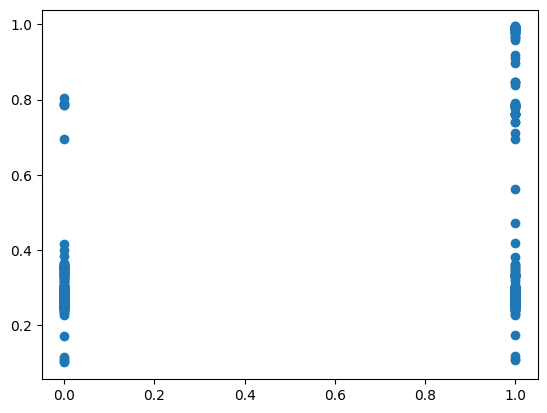

              precision    recall  f1-score   support

           0       0.68      0.97      0.80       497
           1       0.82      0.26      0.40       299

    accuracy                           0.70       796
   macro avg       0.75      0.61      0.60       796
weighted avg       0.74      0.70      0.65       796

0.39593908629441626


In [225]:

#scores = model2.evaluate(X_test, y_test, verbose=1)
print(yhat)
#print(y_test[1])
y_pred_bool = pd.cut(x=yhat.flatten(),bins=[0,0.355,1],labels=[0,1])
#y_pred_bool =  torch.round(torch.tensor(yhat))
#y_pred_bool = y_pred_bool.numpy()
print(collections.Counter(y_pred_bool.tolist()))
plt.scatter(y_test,yhat)
plt.show()
#print(pd.DataFrame(y_pred_bool).describe())
#print("Accuracy: %.2f%%" % (scores[1]*100)) 
print(classification_report(y_test, y_pred_bool))
acc = accuracy_score( y_pred_bool,y_test)
# print(acc)
print(f1_score(y_test, y_pred_bool))

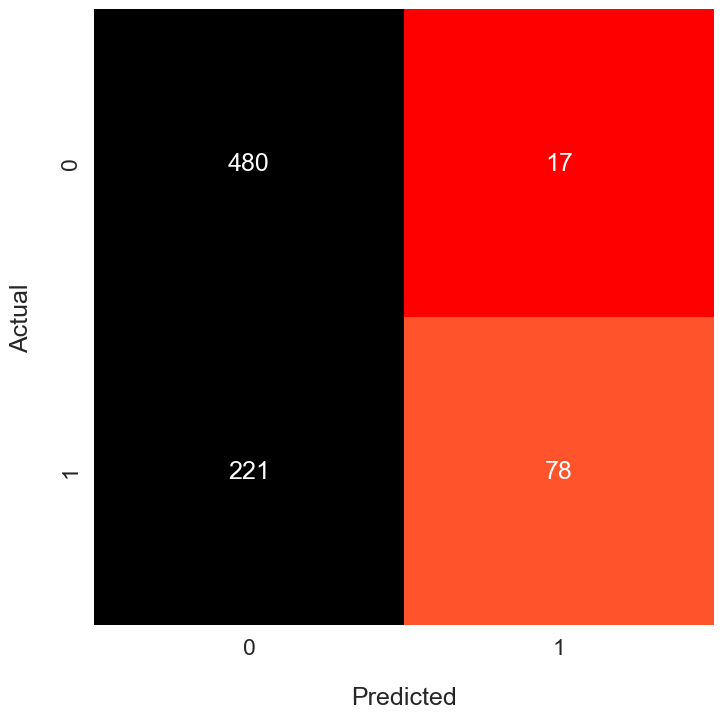

In [226]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

plt.figure(figsize=(8,8))
sns.set(font_scale = 1.5)

ax = sns.heatmap(
    confusion_matrix(y_test, y_pred_bool), # confusion matrix 2D array 
    annot=True, # show numbers in the cells
    fmt='d', # show numbers as integers
    cbar=False, # don't show the color bar
    cmap='flag', # customize color map
    vmax=175 # to get better color contrast
)

ax.set_xlabel("Predicted", labelpad=20)
ax.set_ylabel("Actual", labelpad=20)
plt.show()


[0.29, 0.02, 0.04]
[0.36, 0.9, 0.51]


IndexError: list index out of range